## Model Architecture - ResNet34

Baseline Model

## Installing & Importing Necessary Libraries

In [2]:
#import necessary dependencies
import os
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q wandb
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Using W&B for better logging and visualizations
wandb.init(project="wound-classification-test", config={
    "learning_rate": 0.001,
    "architecture": "ResNet34"
})

wandb: Currently logged in as: samyukta-palle (aipi549). Use `wandb login --relogin` to force relogin


## Loading Data

In [5]:
%cd /content/drive/MyDrive/

!unzip -q WoundDataset.zip -d /content/

/content/drive/MyDrive


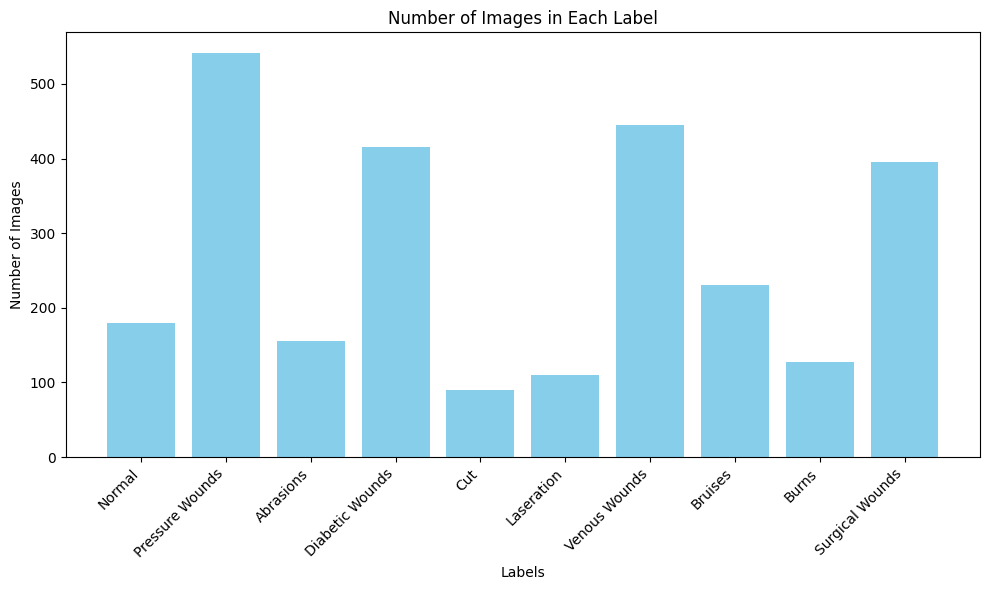

In [6]:
# Path to your dataset directory
data_dir = '/content/WoundDataset/train'

# List all the images in the dataset directory
labels = os.listdir(data_dir)

# Initialize a dictionary to store the count of images in each label
label_count = {}

# Count the number of images in each label
for label in labels:
    label_path = os.path.join(data_dir, label)
    num_images = len(os.listdir(label_path))
    label_count[label] = num_images

# Create a bar graph to visualize the count of images in each label
plt.figure(figsize=(10, 6))
plt.bar(label_count.keys(), label_count.values(), color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preprocessing

Data Transformations

In [7]:
def preprocess(data_dir):
    """
    Preprocesses images in the specified directory.

    Args:
    - data_dir (str): Path to the dataset directory.

    Returns:
    - dataset (torchvision.datasets.ImageFolder): Preprocessed dataset.
    """
    # Define transformations to apply to the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ])

    # Create a dataset from the images in the specified directory
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    return dataset

## Modelling

Train & Validate functions

In [8]:
def train(model, device, trainloader, valloader, criterion, optimizer, epochs, model_path):
    """
    Train the model.

    Args:
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The device to run the training on (e.g., CPU or GPU).
    - trainloader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - valloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - criterion: The loss function.
    - optimizer: The optimization algorithm.
    - epochs (int): Number of epochs to train the model.
    - model_path (str): Path to save the trained model.

    Returns:
    - total_loss (list): List of training losses per epoch.
    """
    best_loss = float('inf')
    total_loss = []

    # Loop through epochs
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch}/{epochs}', unit='batch')

        # Loop through batches in the training data
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix(loss=running_loss / len(progress_bar), accuracy=100 * correct / total)

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total

        # Validation
        val_loss, val_accuracy = validate(model, device, valloader, criterion)

        total_loss.append(train_loss)
        print(val_accuracy)
        # Log metrics to W&B
        wandb.log({"epoch": epoch+1, "train_loss": train_loss, "train_accuracy": train_accuracy,
                   "val_loss": val_loss, "val_accuracy": val_accuracy})

        # Save the model if the validation loss is the best so far
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print("Saving the model")

    print('Training finished!')
    return total_loss

def validate(model, device, valloader, criterion):
    """
    Validate the model.

    Args:
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The device to run the validation on (e.g., CPU or GPU).
    - valloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - criterion: The loss function.

    Returns:
    - val_loss (float): Validation loss.
    - val_accuracy (float): Validation accuracy.
    """
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(valloader, desc='Validation', unit='batch')

    with torch.no_grad():
        # Loop through batches in the validation data
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            val_loss += batch_loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix(loss=val_loss / len(progress_bar), accuracy=100 * correct / total)

    val_loss /= len(valloader)
    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy


In [9]:
import time

# Record the starting time
start_time = time.time()

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Path to the dataset directory
data_dir = '/content/WoundDataset/train'

# Preprocess the dataset
dataset = preprocess(data_dir)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Number of epochs for training
epochs = 15

# Print the unique labels in the dataset
print(set(dataset.targets))

# Loop through folds for cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(dataset.imgs, dataset.targets)):
    print(f'Fold [{fold + 1}/5]')

    # Create train and validation datasets based on fold indices
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    val_dataset = torch.utils.data.Subset(dataset, val_index)

    # Create DataLoader for train and validation datasets
    trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    # Initialize the model (ResNet34) with the appropriate number of output classes
    model = models.resnet34(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)  # 10 classes for the dataset

    # Move the model to the selected device
    model = model.to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize Weights & Biases for logging
    wandb.init(project="wound-classification", name=f"resNet34_fold_{fold}")

    # Define the path to save the trained model
    model_path = f'/content/drive/MyDrive/resnet34_saved_model_fold_{fold}.pth'

    # Train the model for the current fold
    train(model, device, trainloader, valloader, criterion, optimizer, epochs, model_path)

# Record the ending time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Total time taken: {elapsed_time} seconds")

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Fold [1/5]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 38.9MB/s]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.60batch/s, accuracy=44.2, loss=1.73]


44.15584415584416
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.63batch/s, accuracy=56.8, loss=1.22]


56.77179962894249
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.82batch/s, accuracy=56.8, loss=1.22]


56.77179962894249
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.35batch/s, accuracy=63.3, loss=1.13]


63.265306122448976
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.05batch/s, accuracy=71.1, loss=0.822]


71.05751391465677
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.98batch/s, accuracy=55.1, loss=1.43]


55.10204081632653


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.40batch/s, accuracy=67, loss=1.04]


66.97588126159555


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.08batch/s, accuracy=72.5, loss=0.882]


72.5417439703154


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.83batch/s, accuracy=66.6, loss=0.959]


66.6048237476809


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.56batch/s, accuracy=75.5, loss=0.744]


75.51020408163265
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.09batch/s, accuracy=68.5, loss=0.998]


68.46011131725417


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.43batch/s, accuracy=70.1, loss=0.974]


70.12987012987013


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.08batch/s, accuracy=72.5, loss=0.936]


72.5417439703154


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.00batch/s, accuracy=77.7, loss=0.664]


77.73654916512059
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.39batch/s, accuracy=80.9, loss=0.607]


80.89053803339517
Saving the model
Training finished!
Fold [2/5]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
train_loss,█▆▄▄▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▃▅▆▃▅▆▅▇▆▆▆▇█
val_loss,█▅▅▄▂▆▄▃▃▂▃▃▃▁▁
epoch,15
train_accuracy,87.08178
train_loss,0.38656
val_accuracy,80.89054
val_loss,0.60709


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.16batch/s, accuracy=49.6, loss=1.97]


49.62825278810409
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.76batch/s, accuracy=51.1, loss=1.42]


51.11524163568773
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.71batch/s, accuracy=64.1, loss=1.03]


64.1263940520446
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.26batch/s, accuracy=63.4, loss=1.07]


63.38289962825279


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.84batch/s, accuracy=67.1, loss=0.952]


67.1003717472119
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.37batch/s, accuracy=69.3, loss=0.857]


69.33085501858736
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.61batch/s, accuracy=71, loss=0.945]


71.00371747211896


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.79batch/s, accuracy=66.5, loss=1]


66.54275092936803


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.25batch/s, accuracy=73.8, loss=0.825]


73.7918215613383
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.59batch/s, accuracy=74.9, loss=0.78]


74.90706319702602
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.78batch/s, accuracy=78.6, loss=0.647]


78.62453531598513
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.17batch/s, accuracy=79, loss=0.59]


78.99628252788104
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.80batch/s, accuracy=79, loss=0.668]


78.99628252788104


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.74batch/s, accuracy=80.5, loss=0.63]


80.48327137546468


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.17batch/s, accuracy=78.4, loss=0.653]


78.43866171003718
Training finished!
Fold [3/5]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▅▅▅▆▆▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▁▄▄▅▅▆▅▆▇█████
val_loss,█▅▃▃▃▂▃▃▂▂▁▁▁▁▁
epoch,15
train_accuracy,89.36368
train_loss,0.31226
val_accuracy,78.43866
val_loss,0.65342


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.41batch/s, accuracy=45.7, loss=1.64]


45.72490706319702
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.07batch/s, accuracy=54.1, loss=1.5]


54.089219330855016
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.71batch/s, accuracy=58.4, loss=1.29]


58.36431226765799
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.78batch/s, accuracy=61.5, loss=1.08]


61.52416356877323
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.05batch/s, accuracy=67.1, loss=0.989]


67.1003717472119
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.50batch/s, accuracy=63.9, loss=1.17]


63.940520446096656


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.96batch/s, accuracy=73.4, loss=0.749]


73.42007434944237
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.10batch/s, accuracy=73.4, loss=0.728]


73.42007434944237
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.35batch/s, accuracy=71, loss=1.09]


71.00371747211896


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.05batch/s, accuracy=77.5, loss=0.697]


77.5092936802974
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.06batch/s, accuracy=77.9, loss=0.592]


77.88104089219331
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.42batch/s, accuracy=75.5, loss=0.953]


75.46468401486989


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.97batch/s, accuracy=77, loss=0.686]


76.95167286245353


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.91batch/s, accuracy=77.7, loss=0.636]


77.69516728624535


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.50batch/s, accuracy=84.9, loss=0.502]


84.94423791821562
Saving the model
Training finished!
Fold [4/5]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▄▅▆▆▇▇▇▇█▇██
train_loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▅▄▆▆▆▇▇▆▇▇█
val_loss,█▇▆▅▄▅▃▂▅▂▂▄▂▂▁
epoch,15
train_accuracy,88.57408
train_loss,0.35014
val_accuracy,84.94424
val_loss,0.50203


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.27batch/s, accuracy=51.7, loss=1.46]


51.6728624535316
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.00batch/s, accuracy=47.2, loss=1.68]


47.21189591078067


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.99batch/s, accuracy=55.6, loss=1.33]


55.57620817843866
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.21batch/s, accuracy=59.7, loss=1.3]


59.66542750929368
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  4.03batch/s, accuracy=64.9, loss=0.986]


64.86988847583643
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.98batch/s, accuracy=70.4, loss=0.921]


70.4460966542751
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.33batch/s, accuracy=72.7, loss=0.713]


72.67657992565056
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.95batch/s, accuracy=72.1, loss=0.772]


72.11895910780669


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.99batch/s, accuracy=77.5, loss=0.671]


77.5092936802974
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.27batch/s, accuracy=75.7, loss=0.647]


75.65055762081785
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.97batch/s, accuracy=79, loss=0.592]


78.99628252788104
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.64batch/s, accuracy=74.2, loss=0.745]


74.1635687732342


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.49batch/s, accuracy=82.5, loss=0.557]


82.5278810408922
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.97batch/s, accuracy=77.7, loss=0.71]


77.69516728624535


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.45batch/s, accuracy=84, loss=0.533]


84.01486988847584
Saving the model
Training finished!
Fold [5/5]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
train_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
val_accuracy,▂▁▃▃▄▅▆▆▇▆▇▆█▇█
val_loss,▇█▆▆▄▃▂▂▂▂▁▂▁▂▁
epoch,15
train_accuracy,88.06317
train_loss,0.35311
val_accuracy,84.01487
val_loss,0.53325


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.60batch/s, accuracy=51.1, loss=1.4]


51.11524163568773
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.11batch/s, accuracy=54.1, loss=1.47]


54.089219330855016


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.64batch/s, accuracy=59.9, loss=1.15]


59.85130111524163
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.34batch/s, accuracy=66.9, loss=1.02]


66.91449814126393
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.30batch/s, accuracy=67.8, loss=1.02]


67.84386617100371
Saving the model


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.61batch/s, accuracy=73, loss=0.806]


73.04832713754647
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.11batch/s, accuracy=69, loss=0.87]


68.95910780669145


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.68batch/s, accuracy=69.1, loss=0.9]


69.14498141263941


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.65batch/s, accuracy=75.8, loss=0.734]


75.8364312267658
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.06batch/s, accuracy=74.5, loss=0.742]


74.53531598513011


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.67batch/s, accuracy=76.8, loss=0.774]


76.76579925650557


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.70batch/s, accuracy=80.9, loss=0.612]


80.85501858736059
Saving the model


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.11batch/s, accuracy=72.7, loss=0.808]


72.67657992565056


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.66batch/s, accuracy=71.2, loss=1]


71.18959107806691


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.63batch/s, accuracy=82.9, loss=0.665]

82.8996282527881
Training finished!
Total time taken: 2358.4883465766907 seconds


## Plots

Train & Validation Accuracy; Train & Validation Loss is in W&B graphs

Below is Confusion Matrix, Accuracy, precision, recall and F1score for test dataset.

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the best model
best_model_path = '/content/drive/MyDrive/resnet34_saved_model_fold_2.pth'

# Initialize the model (ResNet34) with the appropriate number of output classes
best_model = models.resnet34(pretrained=True)
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, 10)  # 10 classes for the dataset
best_model.load_state_dict(torch.load(best_model_path))
best_model = best_model.to(device)
best_model.eval()

# Define the transformations for inference
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dir = '/content/WoundDataset/test'
# Preprocess the dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create DataLoader for the entire dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_pred_y and y_test are your predicted and actual labels respectively

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Compute recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Compute F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8202247191011236
Precision: 0.8283059404490608
Recall: 0.8202247191011236
F1 Score: 0.8146375394991514


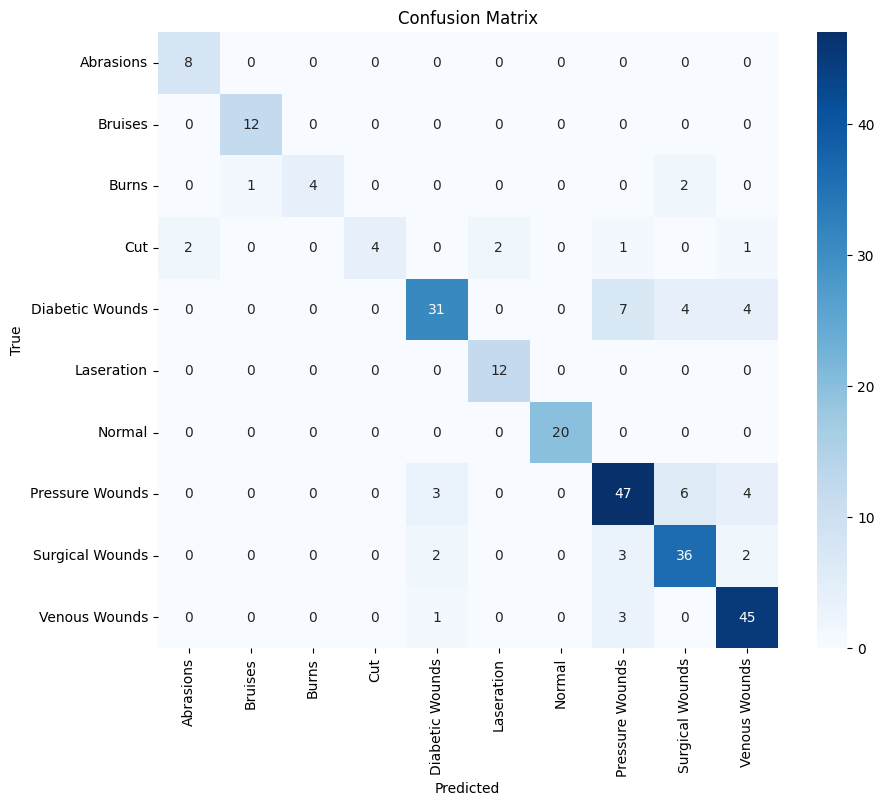

In [13]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Define your class labels
class_labels = ["Abrasions", "Bruises", "Burns", "Cut", "Diabetic Wounds", "Laseration", "Normal", "Pressure Wounds", "Surgical Wounds", "Venous Wounds"]  # Add your class labels here

# Visualize the confusion matrix with class labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()